# Open exploration
Exploring 1000 scenarios over the whole uncertainty space with lhs. 60 replications are used. This notebook includes the following:

- Fitting a linear regression model
- Feature scoring using the extra trees algorithm
- Visual analysis using plotting
- Scenario discovery using PRIM

In [1]:
from ema_workbench.analysis import prim
from ema_workbench import load_results, save_results
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()


In [2]:
# load orginal data
experiments_original, results = load_results('../data/output/EMA/resultsOpenExploration.tar.gz')

In [3]:
# convert groupforming column in experiments to readable format
# e.g. [0.5, 0.38, 0.075, 0.03, 0.015] translates to 50% groupForming
groups = {str([[round(0.5 - num/100, 2), round(0.38 + num/100, 2), 0.075, 0.03, 0.015] for i in range(4)]):(50 + num) for num in range(0, 36)}
experiments = experiments_original.copy()
experiments = experiments.astype({'groupForming': str})
experiments = experiments.replace({'groupForming': groups})

In [4]:
experiments.head()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD,scenario,policy,model
0,80,0.948193,6.935441,42.012624,0.262012,4.0,2.0,5.0,3.0,0,None,model
1,58,0.757105,9.017644,20.245345,0.212828,2.0,3.0,4.0,1.0,1,None,model
2,76,0.947884,9.237989,49.573823,0.201071,1.0,1.0,5.0,1.0,2,None,model
3,56,0.812048,9.385852,49.971579,0.292243,3.0,4.0,1.0,3.0,3,None,model
4,66,1.003328,3.577617,44.399576,0.153377,3.0,1.0,5.0,2.0,4,None,model


In [5]:
experiments.describe()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,67.499000,0.910000,6.000099,27.500870,0.224999,3.000000,3.000000,3.000000,3.000000
std,10.392497,0.144405,2.310649,12.996874,0.043324,1.414921,1.414921,1.414921,1.414921
min,50.000000,0.660393,2.002528,5.018255,0.150019,1.000000,1.000000,1.000000,1.000000
25%,58.750000,0.785104,3.999846,16.262900,0.187507,2.000000,2.000000,2.000000,2.000000
50%,67.500000,0.910121,5.999747,27.501588,0.225036,3.000000,3.000000,3.000000,3.000000
75%,76.250000,1.034917,7.998277,38.756625,0.262481,4.000000,4.000000,4.000000,4.000000
max,85.000000,1.159712,9.997459,49.971579,0.299875,5.000000,5.000000,5.000000,5.000000


In [6]:
results_df = pd.DataFrame(results)
results_df.head()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
0,0.646908,0.118320,0.339979,0.039747,0.131718,0.356664,0.770136,0.214995,0.509934
1,0.507849,0.094262,0.252843,0.045855,0.172944,0.498073,1.398238,0.428227,1.463444
2,0.542297,0.540831,1.197164,0.099565,0.327098,0.481085,1.316462,0.570542,1.724928
3,0.483281,0.062210,0.191109,0.052620,0.183508,0.548171,1.466816,0.234845,0.664376
4,0.743053,0.326605,0.680254,0.078211,0.216227,0.597792,1.370405,0.468048,1.070032


In [7]:
results_df.describe()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.637905,0.150000,0.380243,0.059591,0.195781,0.613698,1.426385,0.366661,0.992363
std,0.097481,0.122963,0.240167,0.027076,0.078951,0.284278,0.716051,0.214246,0.607030
min,0.411067,0.026023,0.105450,0.014338,0.060110,0.199811,0.395398,0.077986,0.223170
25%,0.567022,0.061095,0.204992,0.038539,0.132349,0.391211,0.821999,0.198254,0.490974
50%,0.623854,0.109521,0.307488,0.054853,0.186312,0.571708,1.360363,0.320458,0.862859
75%,0.704376,0.168882,0.452001,0.076078,0.243173,0.774222,1.830220,0.477944,1.361931
max,0.953906,0.544556,1.282528,0.184843,0.524067,1.678983,3.865312,1.380056,3.453806


In [8]:
# drop unneeded columns from experiments for the analysis
X = experiments.drop(['model','policy', 'scenario'], inplace=False, axis=1)

## Visual analysis

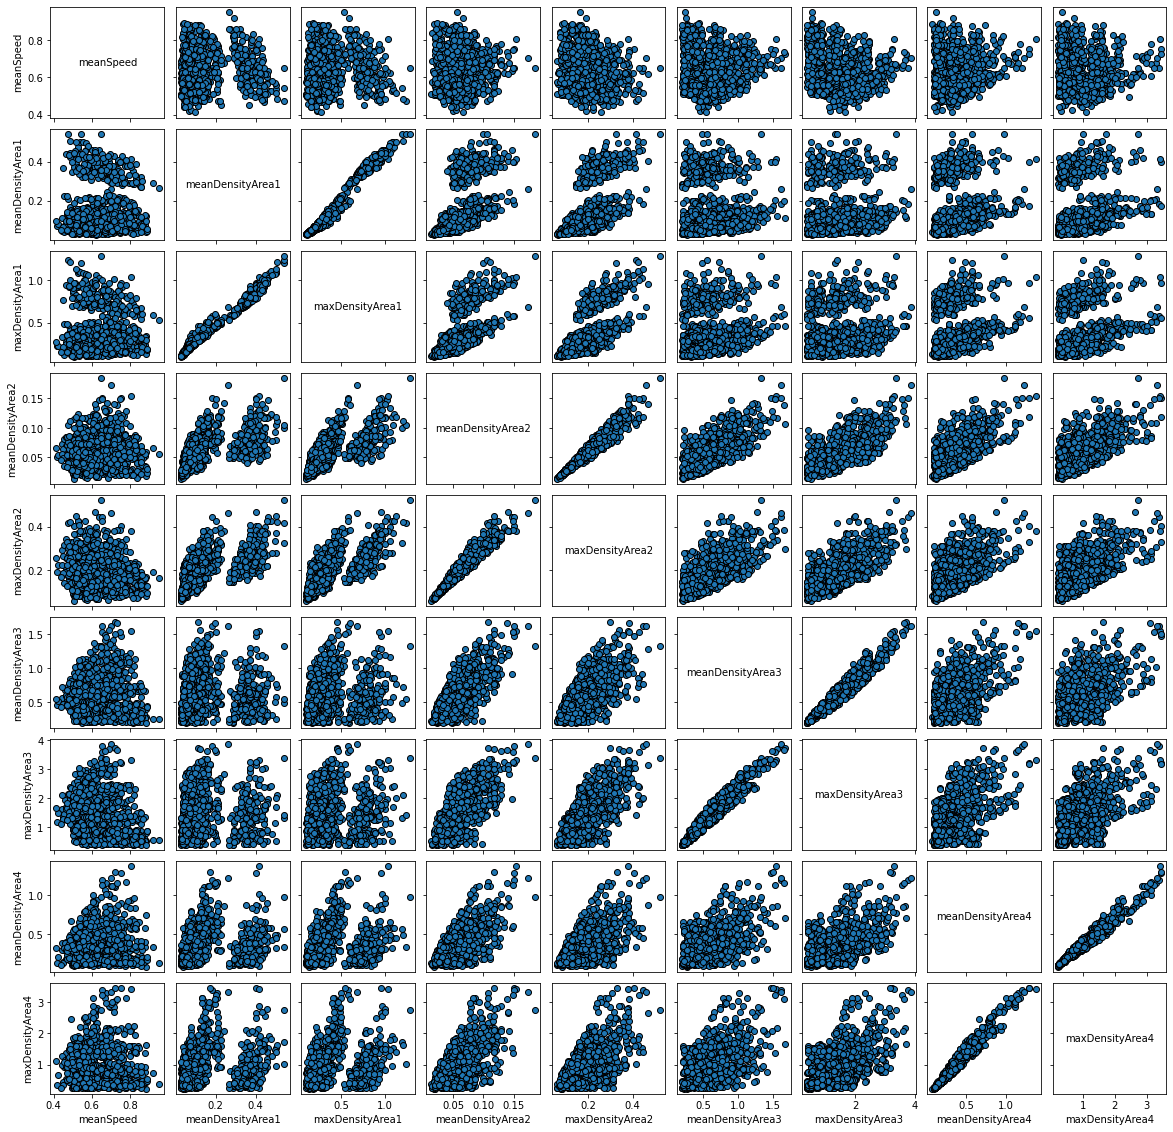

In [9]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments,
    results,
)

fig.set_size_inches(20, 20)
plt.show()

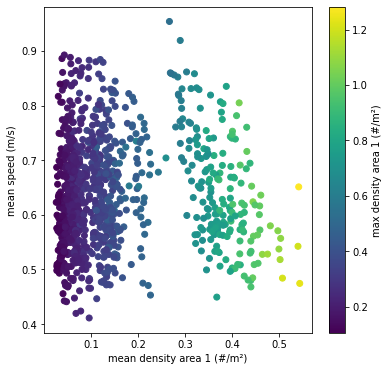

In [10]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(results['meanDensityArea1'], results['meanSpeed'], c=results['maxDensityArea1'])
cbar = plt.colorbar(sc)
cbar.set_label('max density area 1 (#/m²)')
ax.set_xlabel('mean density area 1 (#/m²)')
ax.set_ylabel('mean speed (m/s)')
plt.show()

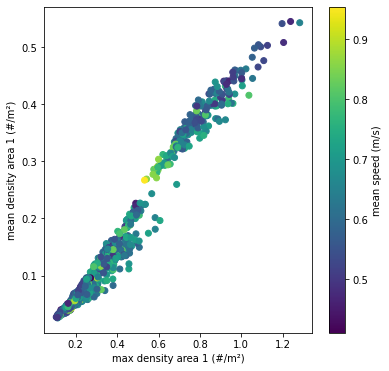

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(results['maxDensityArea1'], results['meanDensityArea1'], c=results['meanSpeed'])
cbar = plt.colorbar(sc)
cbar.set_label('mean speed (m/s)')
ax.set_xlabel('max density area 1 (#/m²)')
ax.set_ylabel('mean density area 1 (#/m²)')
plt.show()

## Linear regression model

In [9]:
import statsmodels.api as sm

# add constant
X_0 = sm.add_constant(X)

In [12]:
# specify outcome to fit linear regression on
outcome = 'meanDensityArea3'
# outcome = 'meanSpeed'

In [13]:
est = sm.OLS(results_df[outcome], X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:       meanDensityArea3   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     870.2
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        09:34:04   Log-Likelihood:                 933.02
No. Observations:                1000   AIC:                            -1846.
Df Residuals:                     990   BIC:                            -1797.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0026    

## Feature scoring

In [15]:
from ema_workbench.analysis import feature_scoring

# use the extra trees algorithm
fs = feature_scoring.get_feature_scores_all(
    x=X,
    y=results,
    alg='extra trees',
)

/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/ema_workbench-2.1.3-py3.10.egg/ema_workbench/analysis/feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-pack

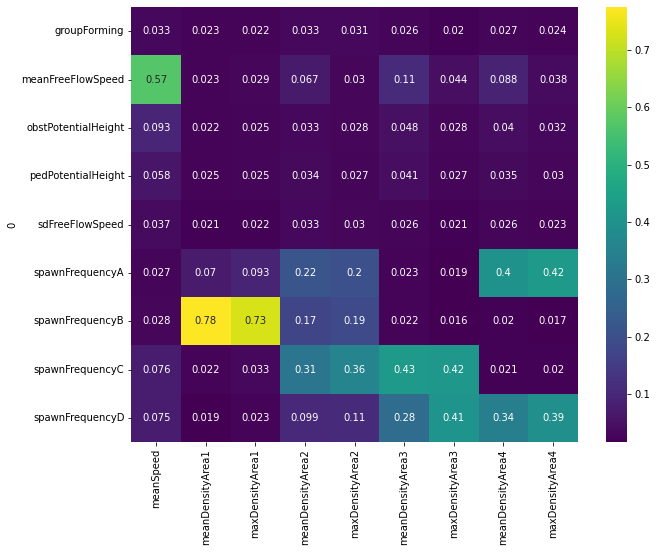

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(fs,
            cmap="viridis",
            annot=True,
            ax=ax)
plt.show()

In [17]:
# repeat for binary clasification
from ema_workbench.analysis import RuleInductionType

x = experiments
y = (
    (results['meanDensityArea1'] > 0.80) |
    (results['meanDensityArea2'] > 0.80) |
    (results['meanDensityArea3'] > 0.80) |
    (results['meanDensityArea4'] > 0.80) 
)

fs, alg = feature_scoring.get_ex_feature_scores(
    x, y, mode=RuleInductionType.CLASSIFICATION
)
fs.sort_values(ascending=False, by=1).round(2)

,1
0,
spawnFrequencyC,0.28
spawnFrequencyD,0.23
meanFreeFlowSpeed,0.15
obstPotentialHeight,0.08
pedPotentialHeight,0.07
spawnFrequencyA,0.05
groupForming,0.05
sdFreeFlowSpeed,0.05
spawnFrequencyB,0.04


## PRIM

In [18]:
x = experiments
y = (
    (results['meanDensityArea1'] > 0.80) |
    (results['meanDensityArea2'] > 0.80) |
    (results['meanDensityArea3'] > 0.80) |
    (results['meanDensityArea4'] > 0.80) 
)
prim_alg = prim.Prim(
    x,
    y,
    threshold=0.6)
box = prim_alg.find_box()

In [19]:
sum(y)

240

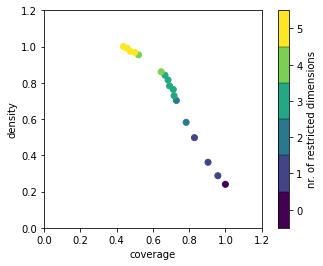

In [20]:
box.show_tradeoff()
plt.show()

In [21]:
box.select(8)

coverage    0.691667
density     0.783019
id          8.000000
mass        0.212000
mean        0.783019
res_dim     3.000000
Name: 8, dtype: float64

                      box 8                                          
                        min       max                       qp values
spawnFrequencyC    1.000000  2.500000  [-1.0, 1.6769104856076525e-26]
spawnFrequencyD    1.000000  3.500000  [-1.0, 1.0049177059414065e-11]
meanFreeFlowSpeed  0.754391  1.159712    [0.005501283692951616, -1.0]



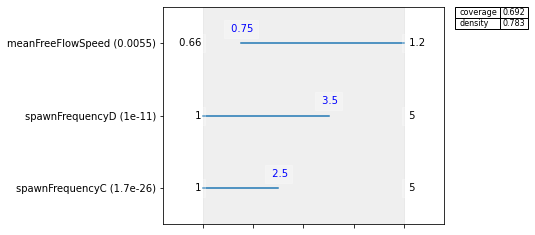

In [22]:
box.inspect()
box.inspect(style="graph")
plt.show()

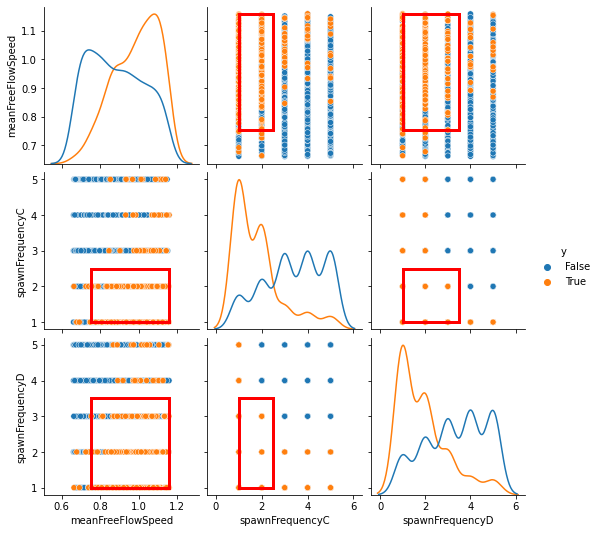

In [23]:
box.show_pairs_scatter()
plt.show()

In [31]:
scenarios_prim = experiments_original.loc[
    ((x['meanFreeFlowSpeed'] >= 0.75) & (x['meanFreeFlowSpeed'] <= 1.16)) &
    ((x['spawnFrequencyD'] >= 1) & (x['spawnFrequencyD'] <= 3.5)) &
    ((x['spawnFrequencyC'] >= 1) & (x['spawnFrequencyC'] <= 2.5)) 
]

In [32]:
# save scenarios and results from those scenarios
results_scenarios_prim = results_df.loc[scenarios_prim.index, :]
scenarios_prim.to_csv('../data/output/EMA/scenariosPrim.csv')
results_scenarios_prim.to_csv('../data/output/EMA/resultsScenariosPrim.csv')

In [35]:
scenarios_prim

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD,scenario,policy,model
3,"[[0.44, 0.44, 0.075, 0.03, 0.015], [0.44, 0.44...",0.812048,9.385852,49.971579,0.292243,3.0,4.0,1.0,3.0,3,None,model
9,"[[0.18, 0.7, 0.075, 0.03, 0.015], [0.18, 0.7, ...",0.957020,8.430520,10.210586,0.190471,1.0,5.0,1.0,2.0,9,None,model
15,"[[0.37, 0.51, 0.075, 0.03, 0.015], [0.37, 0.51...",0.958913,2.487450,45.425453,0.289377,1.0,3.0,1.0,1.0,15,None,model
19,"[[0.16, 0.72, 0.075, 0.03, 0.015], [0.16, 0.72...",0.882790,8.452741,26.658557,0.198093,2.0,4.0,2.0,1.0,19,None,model
21,"[[0.2, 0.68, 0.075, 0.03, 0.015], [0.2, 0.68, ...",1.033572,9.514029,42.419901,0.246426,1.0,5.0,2.0,3.0,21,None,model
...,...,...,...,...,...,...,...,...,...,...,...,...
970,"[[0.39, 0.49, 0.075, 0.03, 0.015], [0.39, 0.49...",0.923761,5.557963,15.221750,0.243115,2.0,2.0,2.0,2.0,970,None,model
971,"[[0.41, 0.47, 0.075, 0.03, 0.015], [0.41, 0.47...",0.895142,3.144162,7.296373,0.279451,5.0,1.0,2.0,2.0,971,None,model
975,"[[0.27, 0.61, 0.075, 0.03, 0.015], [0.27, 0.61...",0.783215,8.055194,34.189364,0.204862,2.0,1.0,1.0,3.0,975,None,model
978,"[[0.48, 0.4, 0.075, 0.03, 0.015], [0.48, 0.4, ...",1.030417,3.391624,19.108024,0.252001,3.0,2.0,2.0,2.0,978,None,model


In [34]:
results_scenarios_prim

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
3,0.483281,0.062210,0.191109,0.052620,0.183508,0.548171,1.466816,0.234845,0.664376
9,0.608246,0.149669,0.506868,0.122823,0.379729,0.998037,2.564919,0.718540,2.053166
15,0.577897,0.170003,0.452223,0.114522,0.358602,1.078449,2.636653,0.822516,2.360074
19,0.537489,0.084006,0.259341,0.069292,0.232867,0.852165,2.388454,0.557988,1.775092
21,0.621802,0.120728,0.381332,0.076397,0.228380,0.633046,1.506987,0.524851,1.406170
...,...,...,...,...,...,...,...,...,...
970,0.660555,0.146647,0.353862,0.074497,0.236606,0.993426,2.452440,0.493533,1.288067
971,0.680314,0.306575,0.677300,0.075921,0.251564,1.010333,2.410548,0.299839,0.742979
975,0.508759,0.447524,0.960567,0.099641,0.367202,0.663224,1.755760,0.312772,0.971679
978,0.747592,0.121705,0.304239,0.067631,0.198278,1.076085,2.390175,0.377214,0.868191
